In [1]:
## libraries
import os
from dotenv import load_dotenv
import pandas as pd
import psycopg2
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load .env file
load_dotenv()

DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "name": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD")
}

connection = psycopg2.connect(
            database=DB_CONFIG["name"],
            user=DB_CONFIG["user"],
            password=DB_CONFIG["password"],
            host=DB_CONFIG["host"],
            port=DB_CONFIG["port"]
        )

## Query data from the database
data = pd.read_sql("SELECT * FROM public.weather_data_0001", connection)

In [3]:
## Dataset settings
data.drop(columns=['id'], inplace=True)
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.sort_values(by="timestamp").reset_index(drop=True)

# Add 3 hour
data["timestamp"] = data["timestamp"] + pd.Timedelta(hours=3)

In [4]:
##### To DO: EDA #####
# 1. Check for missing values
# 2. Summary statistics
# 3. Visualizations
# 4. Correlation analysis
# 5. Time series analysis
# 6. Anomaly detection
# 7. Feature engineering

In [4]:
## 1-Missing values
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
temperature        0
humidity           0
pressure           0
wind_speed         0
wind_direction     0
beaufort           0
direction_code     0
timestamp          0
lux                0
solar_radiation    0
dtype: int64


In [5]:
## 2-Summary statistics
summary_stats = data.describe()
print("Summary statistics:")
summary_stats.T

Summary statistics:


,count,mean,std,min,25%,50%,75%,max
temperature,2175.0,29.532938,3.428283,23.99,26.56,28.44,32.815,38.18
humidity,2175.0,50.951660,14.265252,20.71,40.66,50.22,63.175,80.02
pressure,2175.0,999.280855,1.547288,995.06,998.40,999.74,1000.380,1001.95
wind_speed,2175.0,0.294253,0.494430,0.00,0.00,0.00,0.500,3.40
wind_direction,2175.0,241.211448,128.393195,0.00,119.35,303.60,338.800,359.90
beaufort,2175.0,0.388966,0.547191,0.00,0.00,0.00,1.000,3.00
direction_code,2175.0,8.697011,6.309166,0.00,1.00,12.00,14.000,15.00
lux,2175.0,3586.435867,4160.791367,0.06,0.13,451.58,7483.390,14708.74
solar_radiation,2175.0,28.332234,32.870427,0.00,0.00,3.57,59.120,116.20


In [6]:
## Add Beaufort scale
def wind_to_beaufort(ws):
    if ws < 1: return 0
    elif ws < 6: return 1
    elif ws < 12: return 2
    elif ws < 20: return 3
    elif ws < 29: return 4
    elif ws < 39: return 5
    elif ws < 50: return 6
    elif ws < 62: return 7
    elif ws < 75: return 8
    elif ws < 89: return 9
    elif ws < 103: return 10
    elif ws < 118: return 11
    else: return 12


## Add vectoral wind components
data["wd_rad"] = np.deg2rad(data["wind_direction"])
data["u"] = np.cos(data["wd_rad"]) * data["wind_speed"]   # x bileşeni
data["v"] = np.sin(data["wd_rad"]) * data["wind_speed"]   # y bileşeni

hourly_data = data[["timestamp","temperature","humidity","pressure","wind_speed","solar_radiation","u","v"]].set_index("timestamp").resample("H").mean().reset_index()


# Ortalama yönü yeniden hesapla
hourly_data["wind_direction"] = np.rad2deg(np.arctan2(hourly_data["v"], hourly_data["u"])) % 360

## Set beaufort scale
hourly_data["beaufort"] = hourly_data["wind_speed"].apply(wind_to_beaufort)

data = hourly_data.copy()

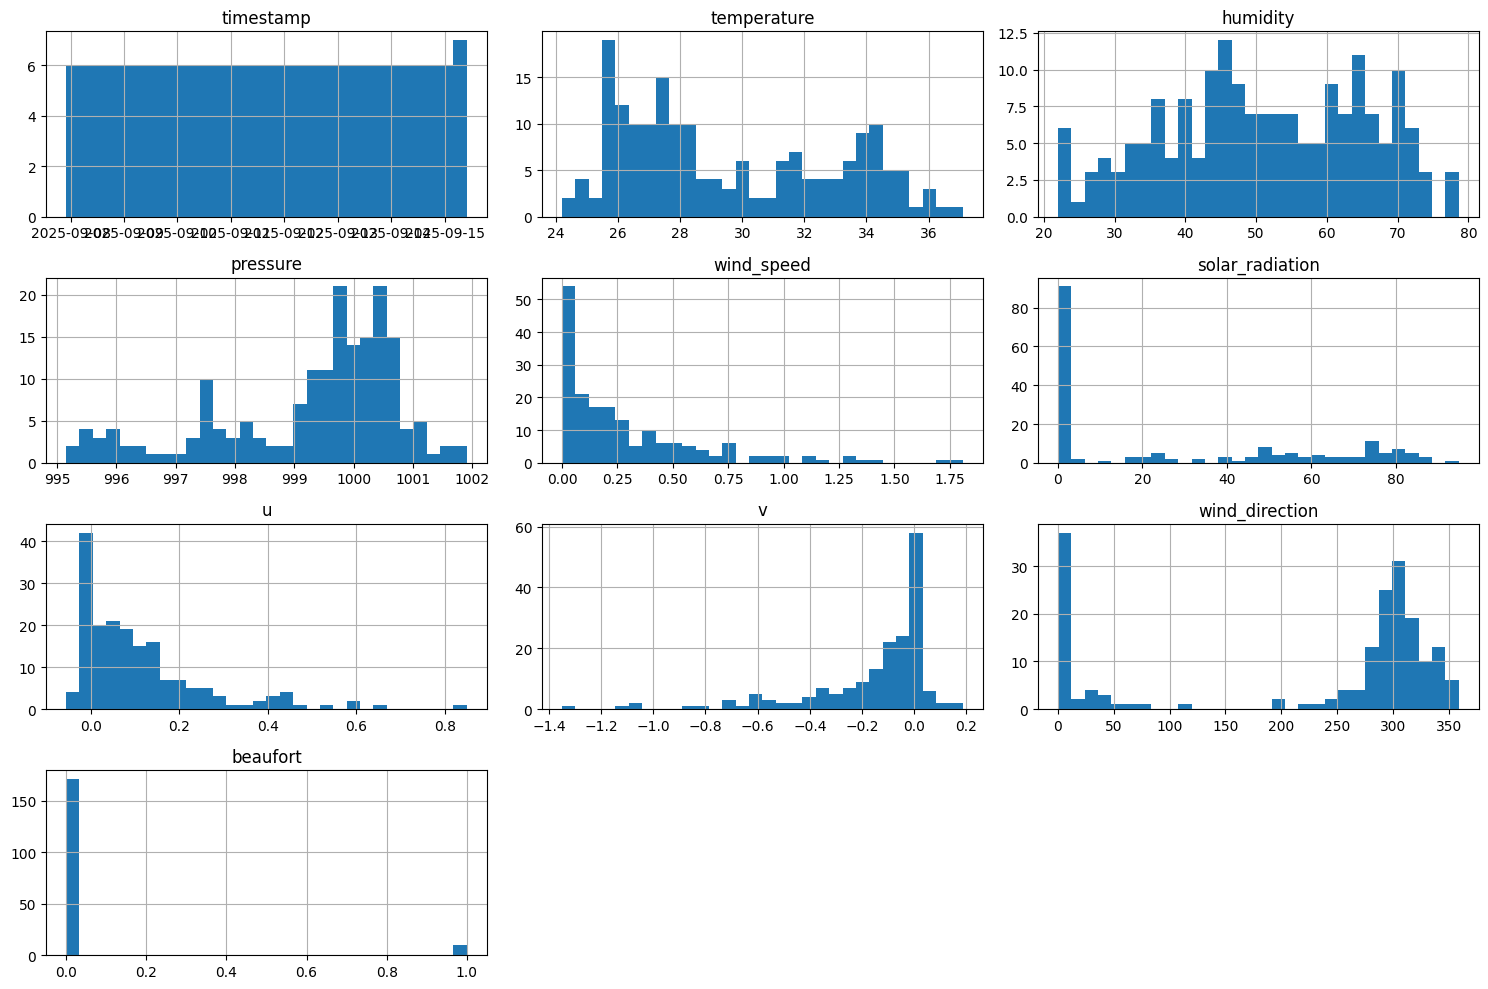

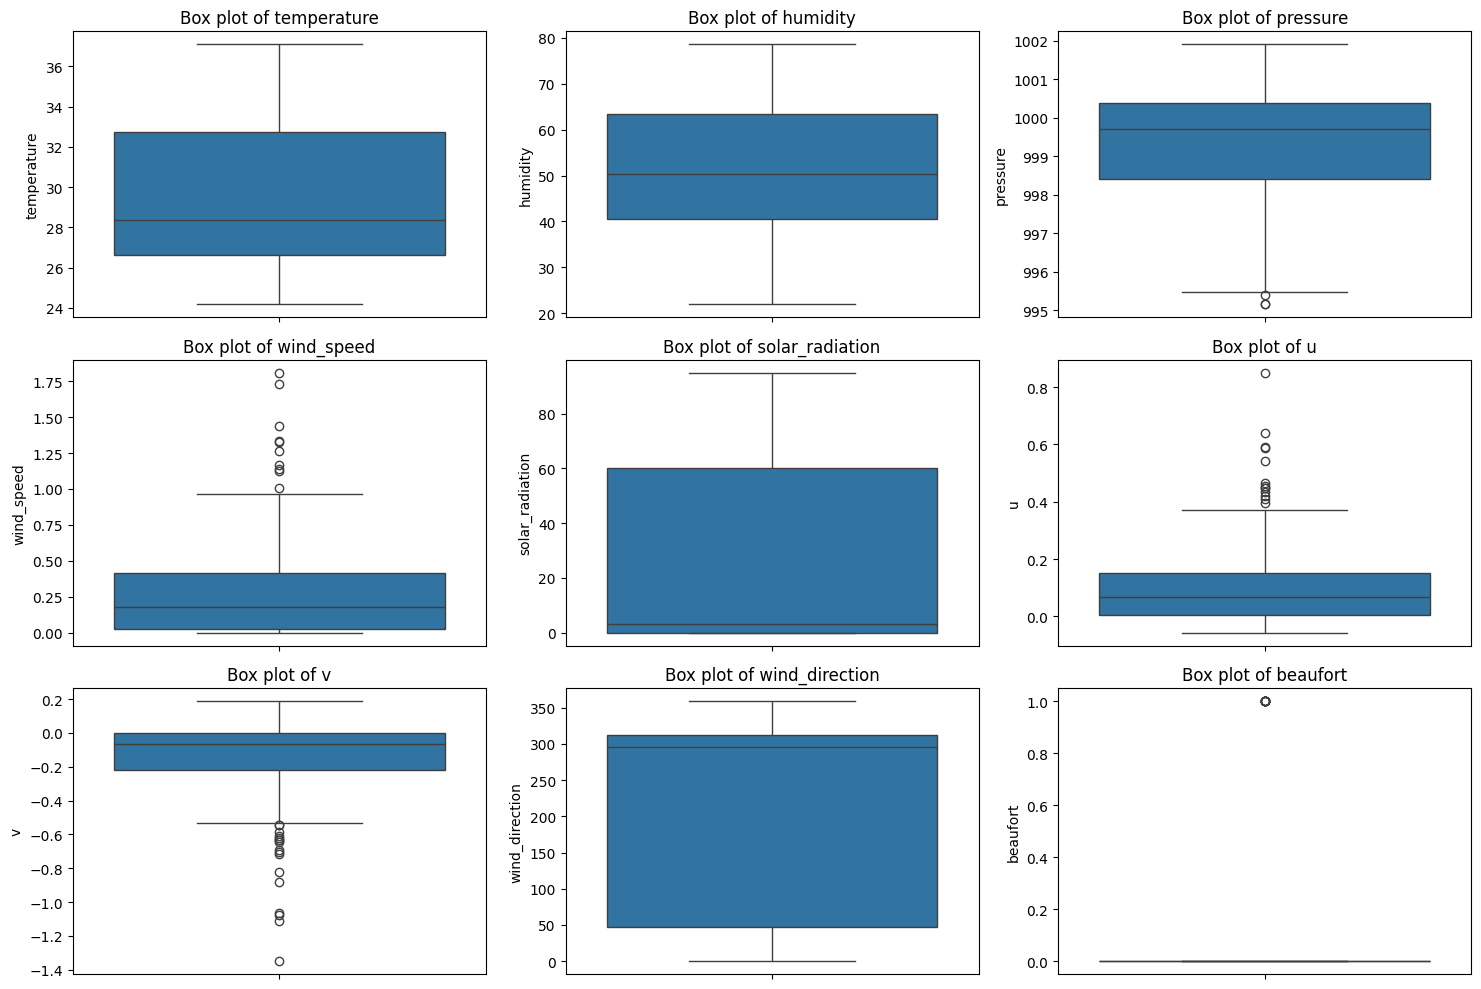

In [7]:
## 3-Visualizations

numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

import matplotlib.pyplot as plt
import seaborn as sns
# Multiple histograms
data.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()
# Box plots
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=data[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()


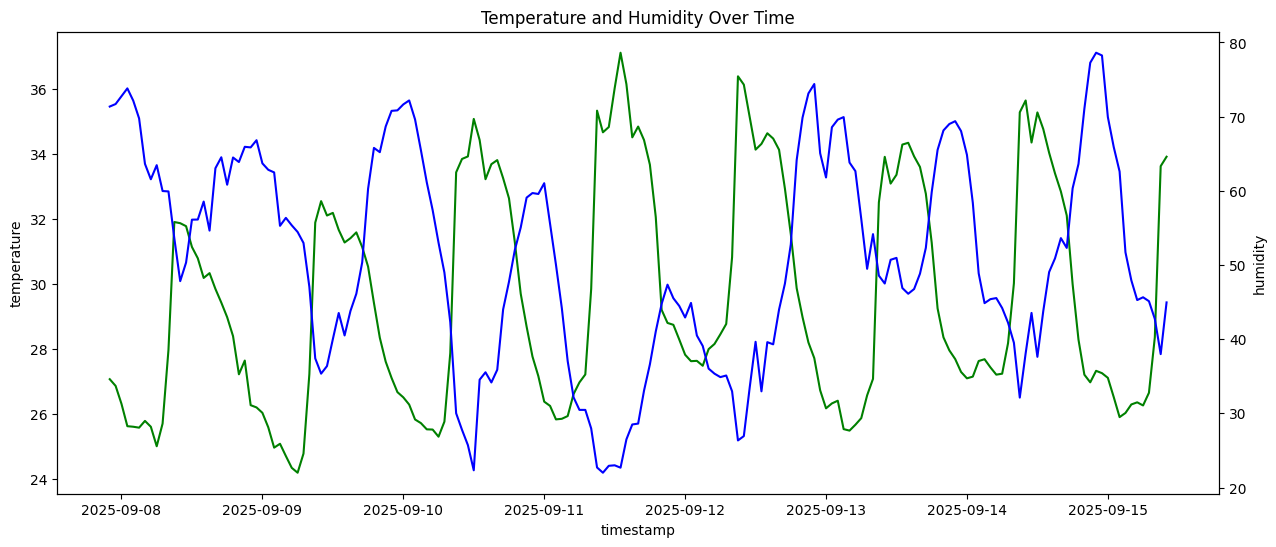

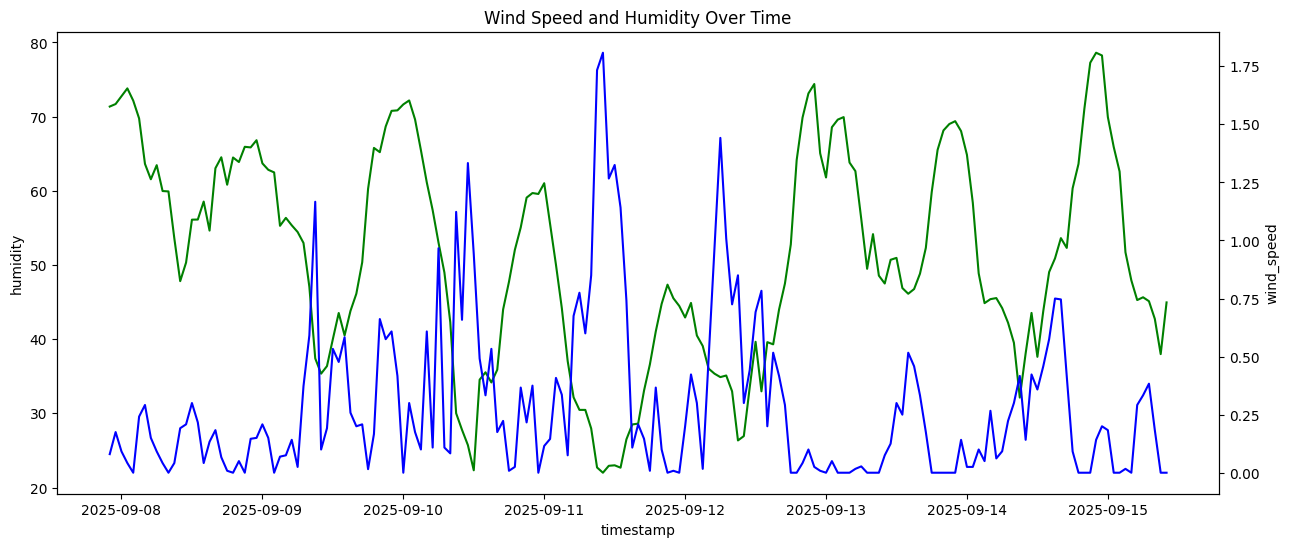

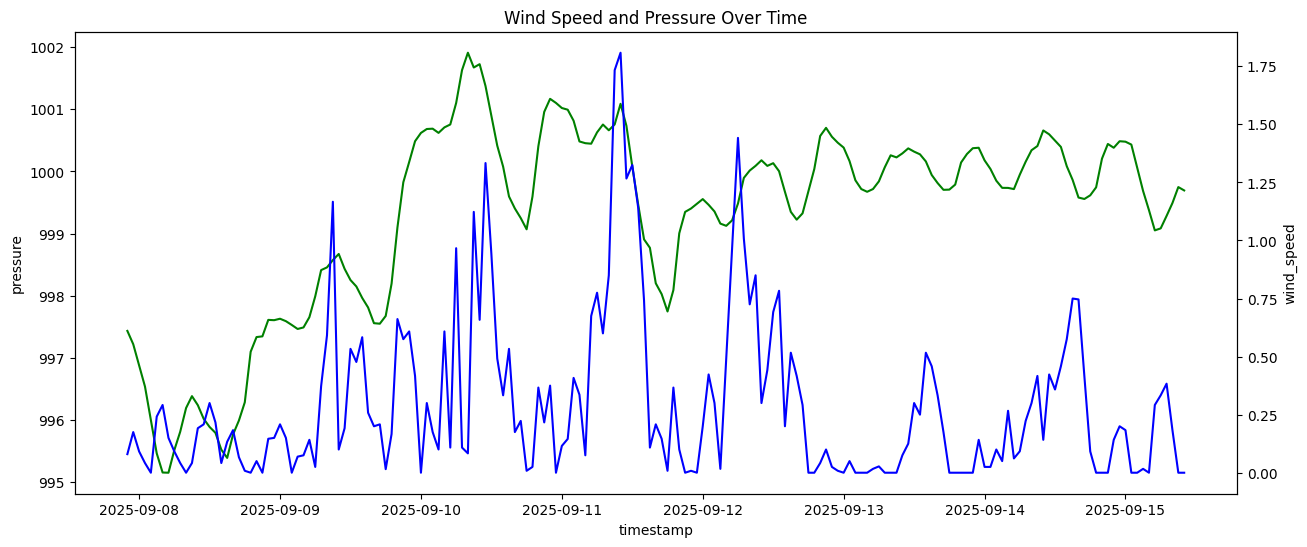

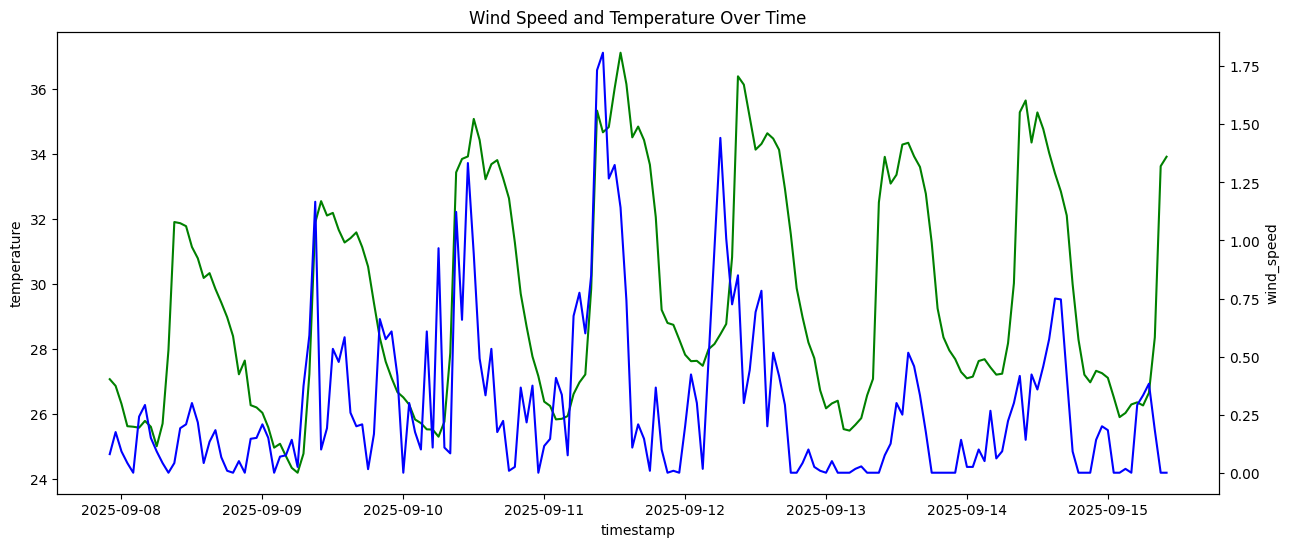

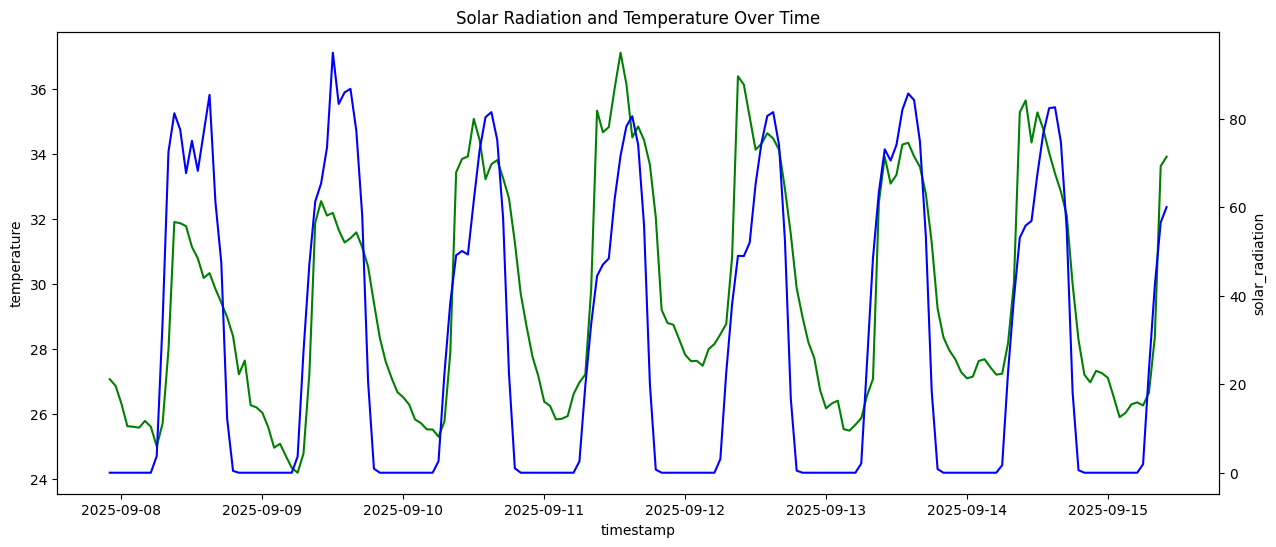

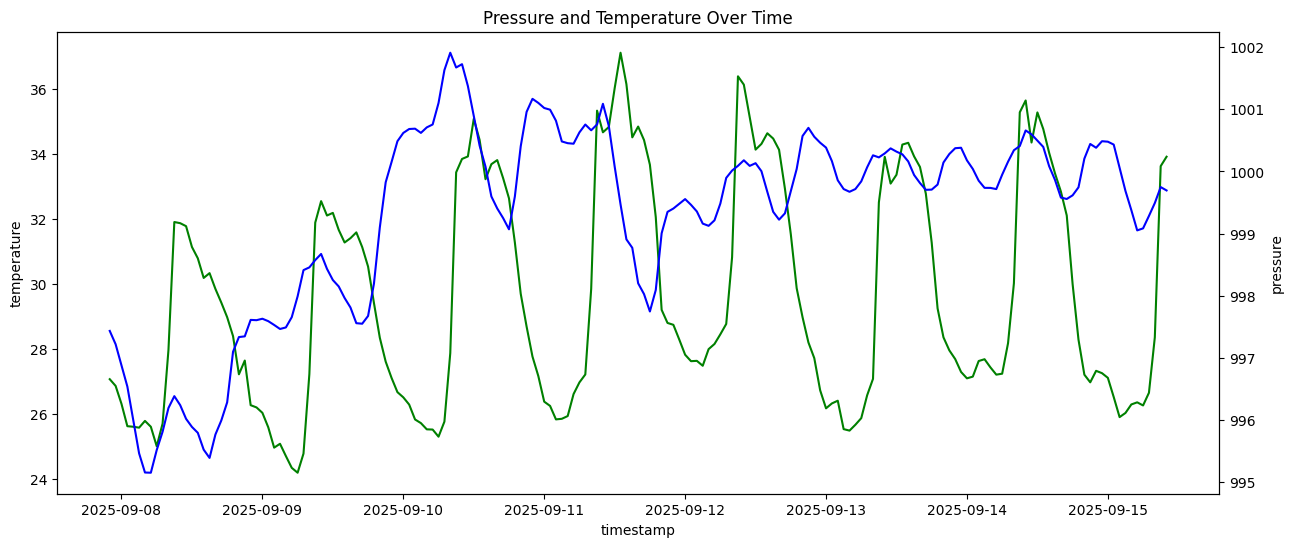

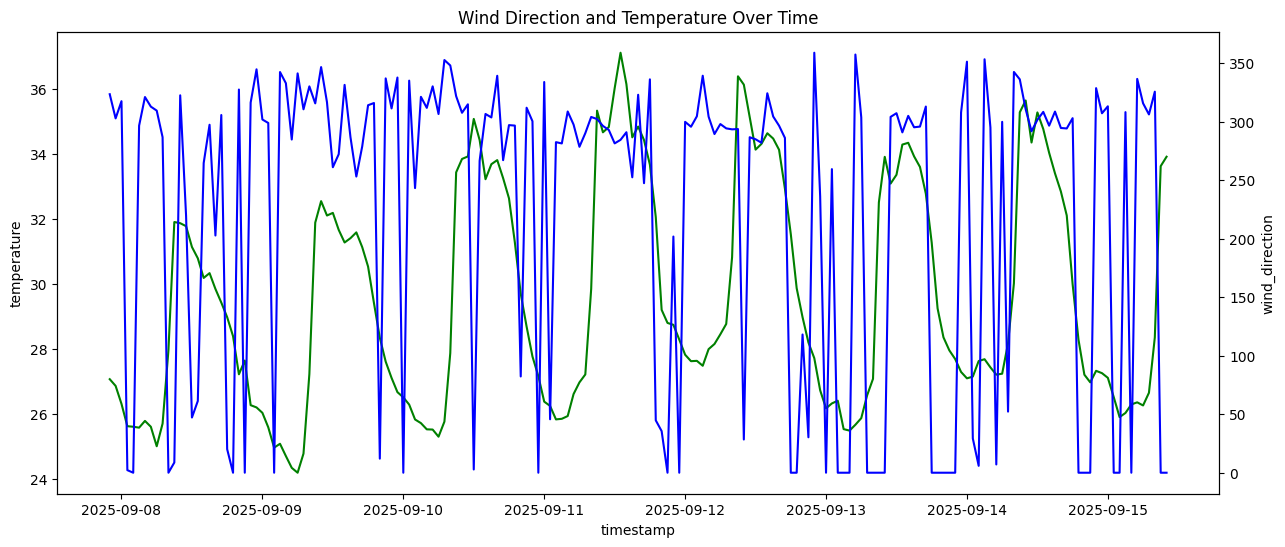

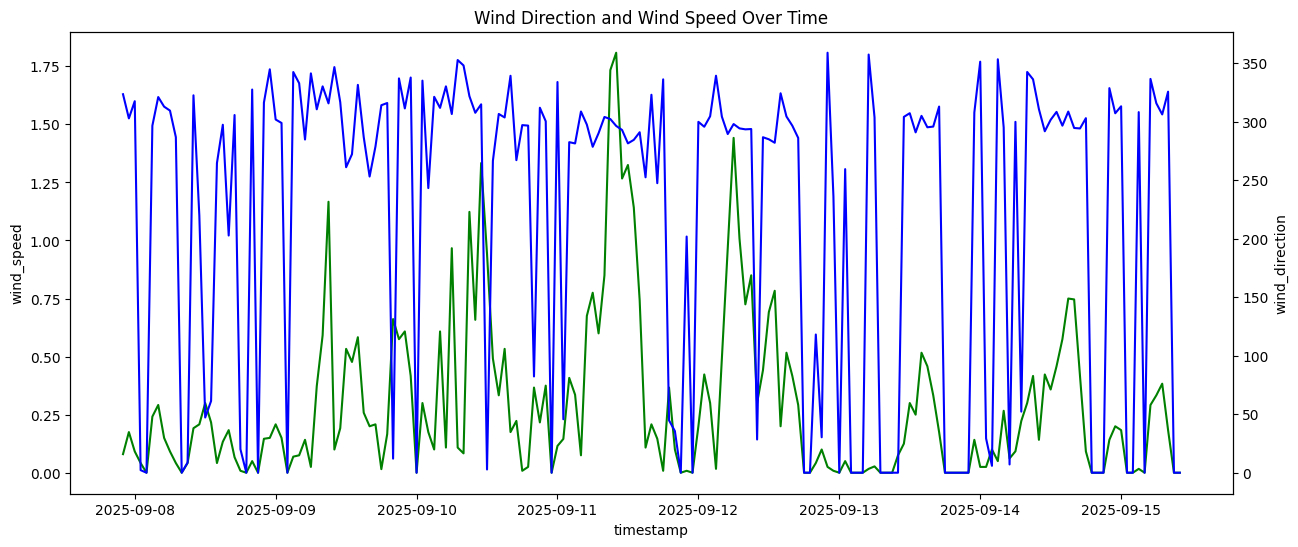

In [8]:
## Temporal trends two axis line plot
### Temperature and Humidity Over Time
plt.figure(figsize=(15, 6))
plt.title("Temperature and Humidity Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="humidity", color="b", ax=ax2)
plt.show()

### Wind Speed and Precipitation Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Speed and Humidity Over Time")
sns.lineplot(data=data,x="timestamp",y="humidity",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_speed", color="b", ax=ax2)
plt.show()

### Wind Speed and Pressure Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Speed and Pressure Over Time")
sns.lineplot(data=data,x="timestamp",y="pressure",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_speed", color="b", ax=ax2)
plt.show()

### Temperature and Wind Speed Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Speed and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_speed", color="b", ax=ax2)
plt.show()


### Temperature and Solar Radiation Over Time
plt.figure(figsize=(15, 6))
plt.title("Solar Radiation and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="solar_radiation", color="b", ax=ax2)
plt.show()


### Temperature and Pressure Over Time
plt.figure(figsize=(15, 6))
plt.title("Pressure and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="pressure", color="b", ax=ax2)
plt.show()

### Temperature and Wind Direction Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Direction and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_direction", color="b", ax=ax2)
plt.show()

### Wind Speed and Wind Direction Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Direction and Wind Speed Over Time")
sns.lineplot(data=data,x="timestamp",y="wind_speed",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_direction", color="b", ax=ax2)
plt.show()

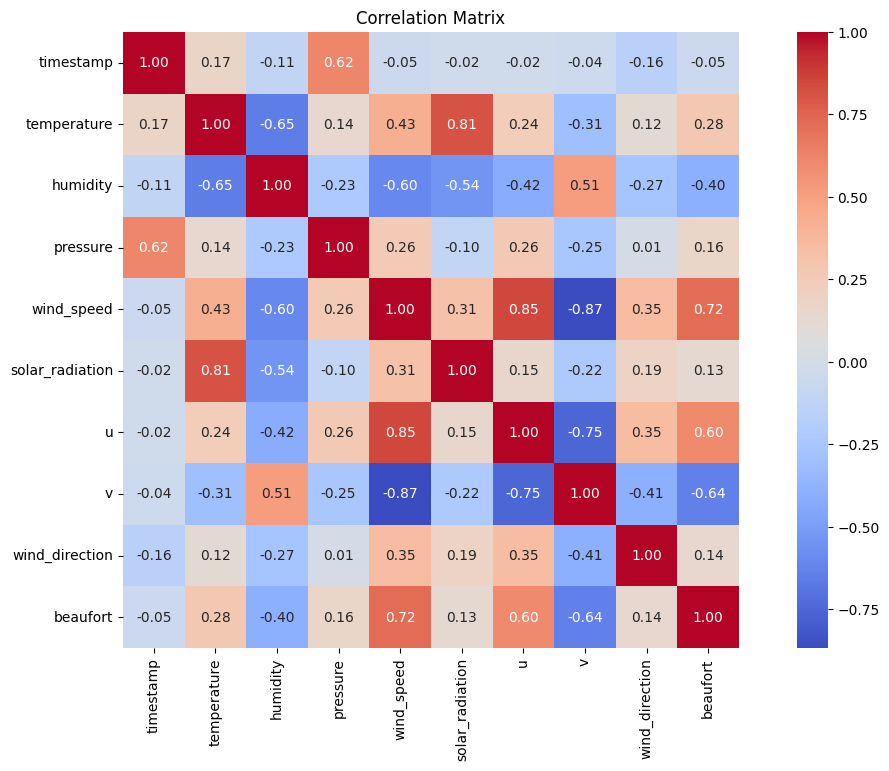

In [9]:
##Correlation analysis
corr_matrix = data.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

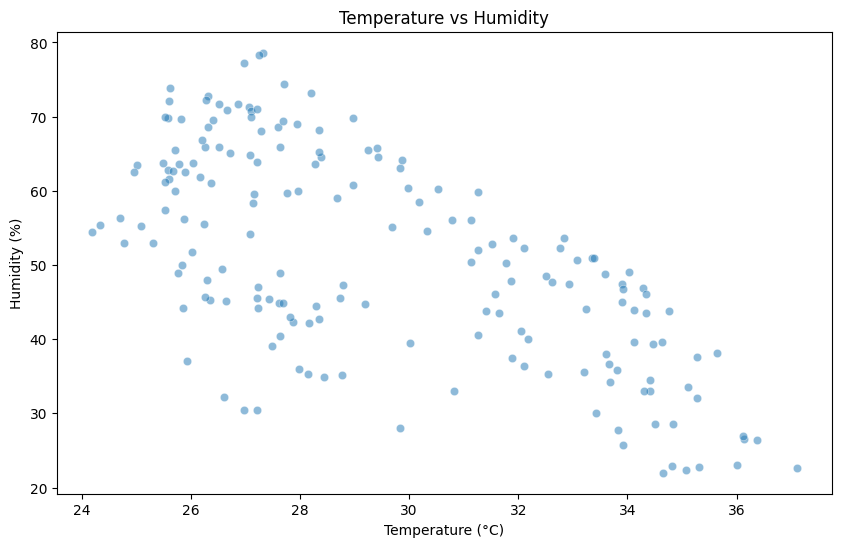

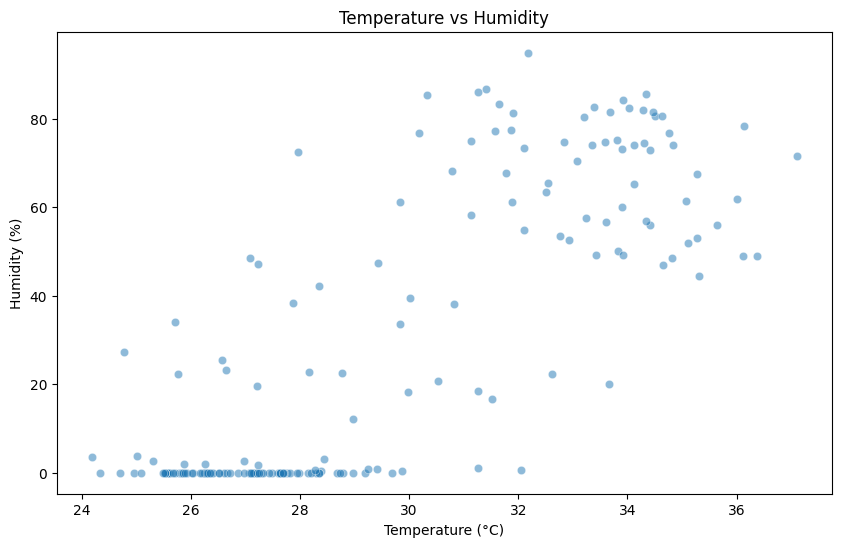

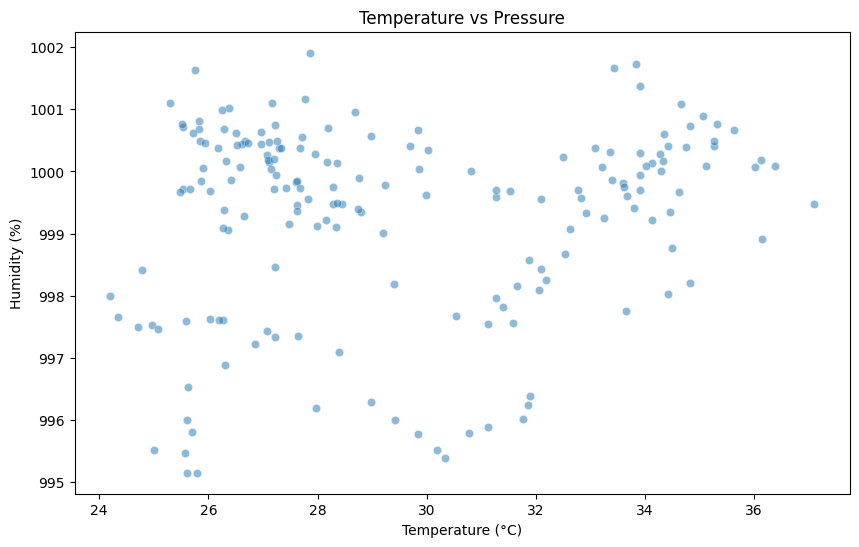

In [10]:
## Temperature and Humidity Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="temperature", y="humidity", alpha=0.5)
plt.title("Temperature vs Humidity")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.show()

## Temperature and Humidity Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="temperature", y="solar_radiation", alpha=0.5)
plt.title("Temperature vs Humidity")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.show()

## Temperature and Pressure Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="temperature", y="pressure", alpha=0.5)
plt.title("Temperature vs Pressure")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.show()

In [11]:
## Add hour, day, month, year columns
### add 3 hour timestamp

data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year
data["week"] = data['timestamp'].dt.isocalendar().week

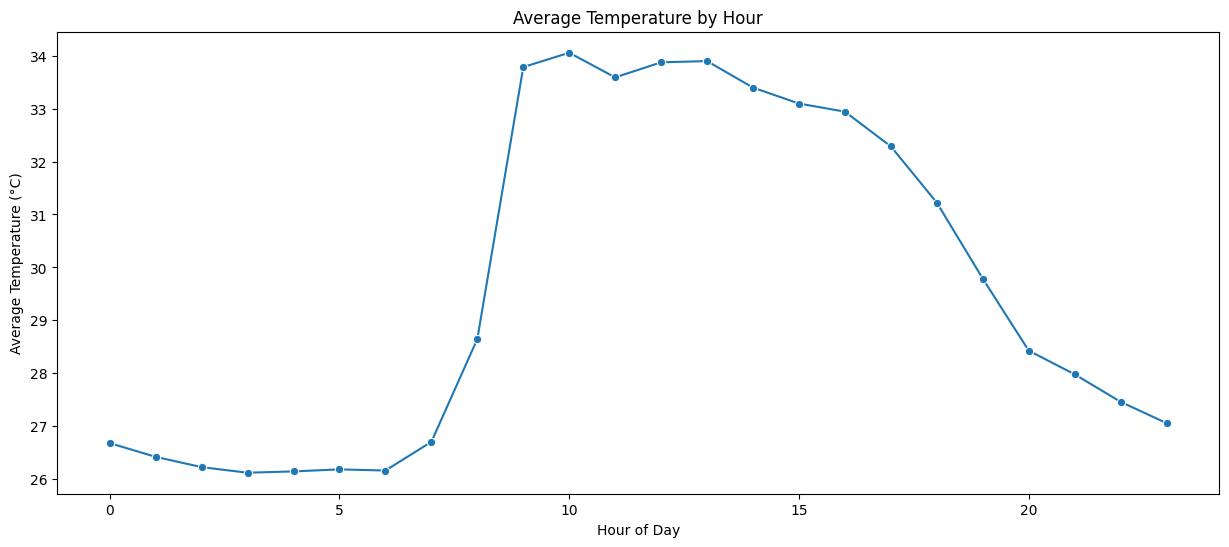

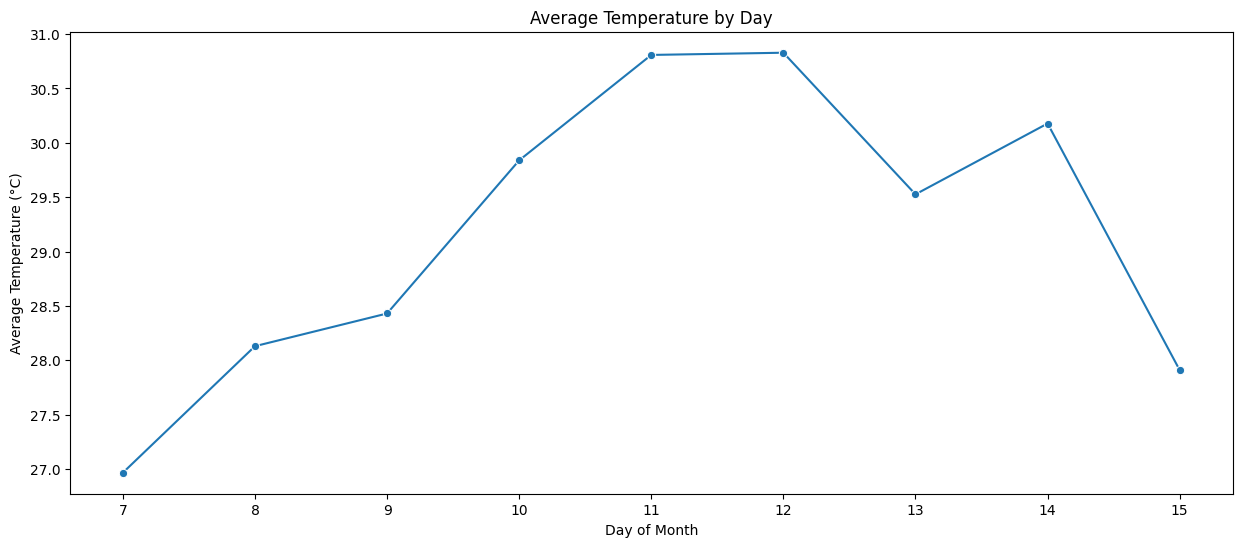

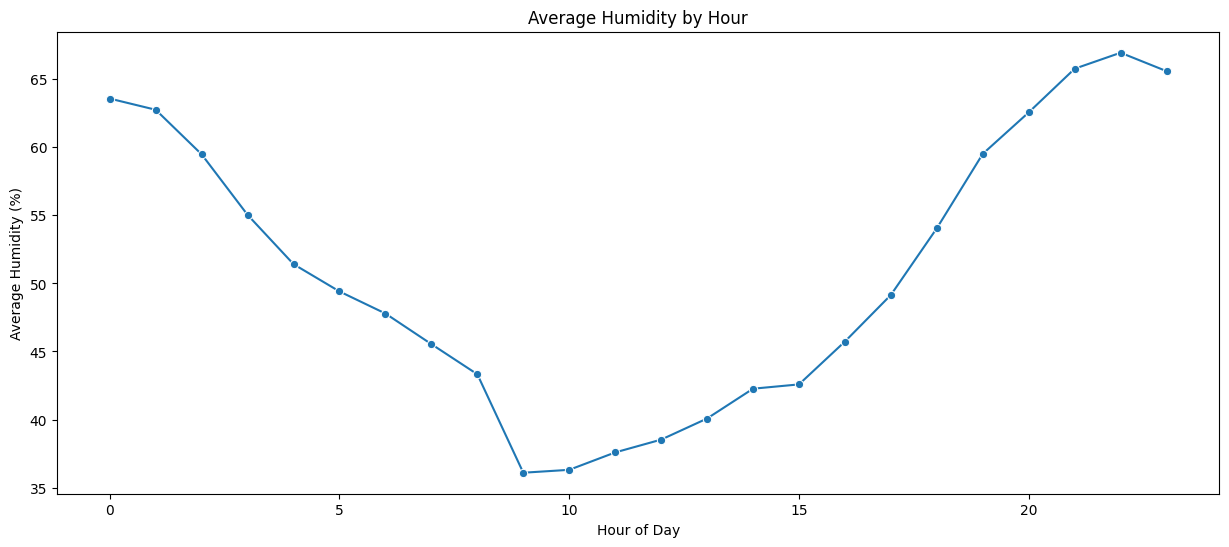

In [12]:
## Avg temperature by hour
avg_temp_by_hour = data.groupby('hour')['temperature'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(data=avg_temp_by_hour, x='hour', y='temperature', marker='o')
plt.title("Average Temperature by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Temperature (°C)")
plt.show()

## Avg temperature by day
avg_temp_by_day = data.groupby('day')['temperature'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(data=avg_temp_by_day, x='day', y='temperature', marker='o')
plt.title("Average Temperature by Day")
plt.xlabel("Day of Month")
plt.ylabel("Average Temperature (°C)")
plt.show()

##Avg humidity by hour
avg_humidity_by_hour = data.groupby('hour')['humidity'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(data=avg_humidity_by_hour, x='hour', y='humidity', marker='o')
plt.title("Average Humidity by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Humidity (%)")
plt.show()

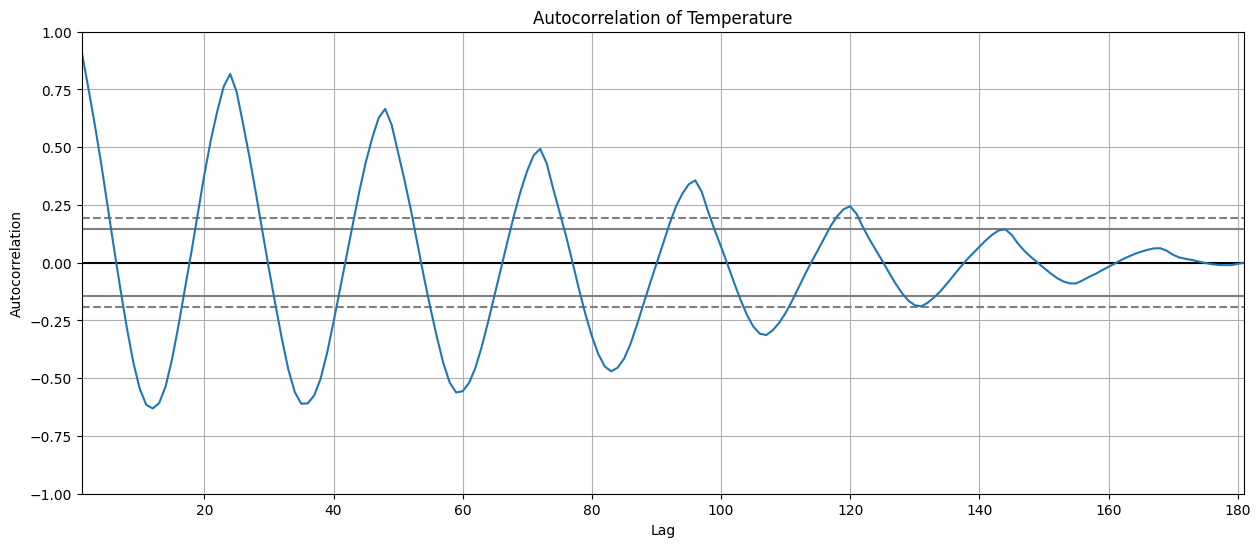

In [13]:
## Autocorrelation analysis
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15, 6))
autocorrelation_plot(data['temperature'])
plt.title("Autocorrelation of Temperature")
plt.show()

In [14]:
## Add lag features
shift_values = [1,2,3,6,12,24]

for shift in shift_values:
    data[f'temperature_lag_{shift}'] = data['temperature'].shift(shift)
    data[f'humidity_lag_{shift}'] = data['humidity'].shift(shift)
    data[f'pressure_lag_{shift}'] = data['pressure'].shift(shift)
    data[f'wind_speed_lag_{shift}'] = data['wind_speed'].shift(shift)
    data[f'solar_radiation_lag_{shift}'] = data['solar_radiation'].shift(shift)

## Add rolling mean features
window_sizes = [3,6,12,24]
for window in window_sizes:
    data[f'temperature_roll_mean_{window}'] = data['temperature'].rolling(window=window).mean()
    data[f'humidity_roll_mean_{window}'] = data['humidity'].rolling(window=window).mean()
    data[f'pressure_roll_mean_{window}'] = data['pressure'].rolling(window=window).mean()
    data[f'wind_speed_roll_mean_{window}'] = data['wind_speed'].rolling(window=window).mean()
    data[f'solar_radiation_roll_mean_{window}'] = data['solar_radiation'].rolling(window=window).mean()

## Add rolling std features
for window in window_sizes:
    data[f'temperature_roll_std_{window}'] = data['temperature'].rolling(window=window).std()
    data[f'humidity_roll_std_{window}'] = data['humidity'].rolling(window=window).std()
    data[f'pressure_roll_std_{window}'] = data['pressure'].rolling(window=window).std()
    data[f'wind_speed_roll_std_{window}'] = data['wind_speed'].rolling(window=window).std()
    data[f'solar_radiation_roll_std_{window}'] = data['solar_radiation'].rolling(window=window).std()

## Add hourly, daily, weekly, monthly sin and cos features
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)
data['week_sin'] = np.sin(2 * np.pi * data['week'] / 52)
data['week_cos'] = np.cos(2 * np.pi * data['week'] / 52)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['year_sin'] = np.sin(2 * np.pi * (data['year'] - data['year'].min()) / (data['year'].max() - data['year'].min()))
data['year_cos'] = np.cos(2 * np.pi * (data['year'] - data['year'].min()) / (data['year'].max() - data['year'].min()))

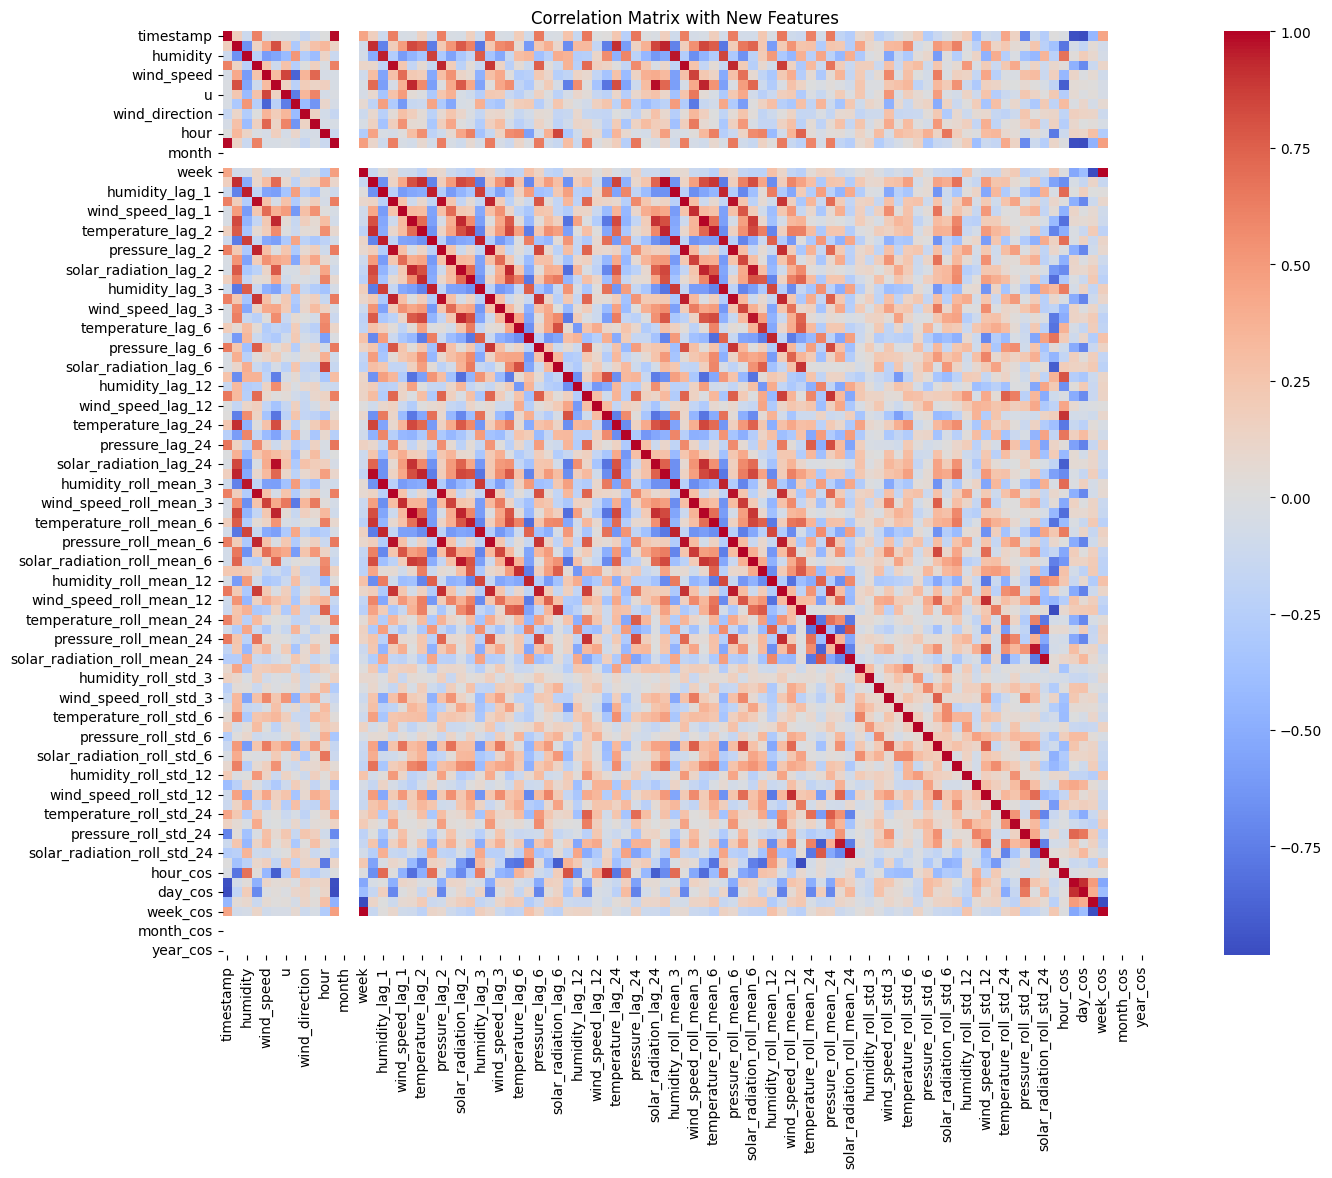

In [15]:
## Check correlation of new features
corr_matrix = data.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix with New Features")
plt.show()

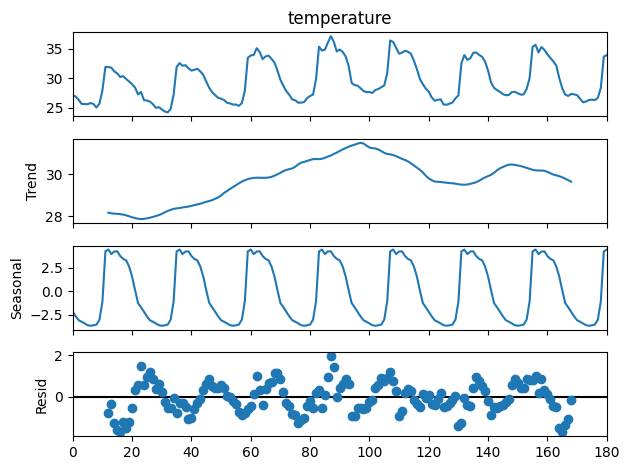

In [16]:
## time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['temperature'].dropna(), model='additive', period=24)
result.plot()
plt.show()

In [17]:
data

,timestamp,temperature,humidity,pressure,wind_speed,solar_radiation,u,v,wind_direction,beaufort,...,hour_sin,hour_cos,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,year_sin,year_cos
0,2025-09-07 22:00:00+00:00,27.068000,71.356000,997.436000,0.080000,0.000000,0.064225,-0.047698,323.400000,0,...,-0.500000,8.660254e-01,0.988468,0.151428,-0.935016,-0.354605,-1.0,-1.836970e-16,NaN,NaN
1,2025-09-07 23:00:00+00:00,26.861667,71.695833,997.221667,0.175000,0.000000,0.089978,-0.139839,302.758940,0,...,-0.258819,9.659258e-01,0.988468,0.151428,-0.935016,-0.354605,-1.0,-1.836970e-16,NaN,NaN
2,2025-09-08 00:00:00+00:00,26.310000,72.752500,996.880000,0.091667,0.000000,0.066852,-0.061346,317.459654,0,...,0.000000,1.000000e+00,0.998717,-0.050649,-0.970942,-0.239316,-1.0,-1.836970e-16,NaN,NaN
3,2025-09-08 01:00:00+00:00,25.623333,73.805000,996.540833,0.041667,0.000000,0.041636,0.001599,2.200000,0,...,0.258819,9.659258e-01,0.998717,-0.050649,-0.970942,-0.239316,-1.0,-1.836970e-16,NaN,NaN
4,2025-09-08 02:00:00+00:00,25.606667,72.156667,995.999167,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0.500000,8.660254e-01,0.998717,-0.050649,-0.970942,-0.239316,-1.0,-1.836970e-16,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2025-09-15 06:00:00+00:00,26.260833,45.645833,999.085000,0.333333,1.920000,0.214178,-0.209390,315.647617,0,...,1.000000,6.123234e-17,0.101168,-0.994869,-0.992709,-0.120537,-1.0,-1.836970e-16,NaN,NaN
177,2025-09-15 07:00:00+00:00,26.650833,45.117500,999.285000,0.383333,23.265000,0.151129,-0.206982,306.135255,0,...,0.965926,-2.588190e-01,0.101168,-0.994869,-0.992709,-0.120537,-1.0,-1.836970e-16,NaN,NaN
178,2025-09-15 08:00:00+00:00,28.354167,42.735000,999.492500,0.183333,42.259167,0.146018,-0.100107,325.566233,0,...,0.866025,-5.000000e-01,0.101168,-0.994869,-0.992709,-0.120537,-1.0,-1.836970e-16,NaN,NaN
179,2025-09-15 09:00:00+00:00,33.615833,37.984167,999.749167,0.000000,56.550000,0.000000,0.000000,0.000000,0,...,0.707107,-7.071068e-01,0.101168,-0.994869,-0.992709,-0.120537,-1.0,-1.836970e-16,NaN,NaN


In [18]:
model_data = data.copy()
model_data.drop(["u","v","humidity","pressure","wind_speed","solar_radiation","beaufort"], axis=1, inplace=True)

## Create test, train and validation sets
train_size = int(len(model_data) * 0.85)
val_size = int(len(model_data) * 0.05)
train = model_data[:train_size]
val = model_data[train_size:train_size + val_size]
test = model_data[train_size + val_size:]

0:	learn: 2.4536506	test: 3.3312305	best: 3.3312305 (0)	total: 141ms	remaining: 42.1s
100:	learn: 0.0222197	test: 1.1162736	best: 1.0976379 (36)	total: 322ms	remaining: 634ms
200:	learn: 0.0011496	test: 1.1147955	best: 1.0976379 (36)	total: 504ms	remaining: 248ms
299:	learn: 0.0001002	test: 1.1146320	best: 1.0976379 (36)	total: 657ms	remaining: 0us

bestTest = 1.097637874
bestIteration = 36

Shrink model to first 37 iterations.
Validation MAE: 0.93
Validation RMSE: 1.10
Test MAE: 0.52
Test RMSE: 0.61


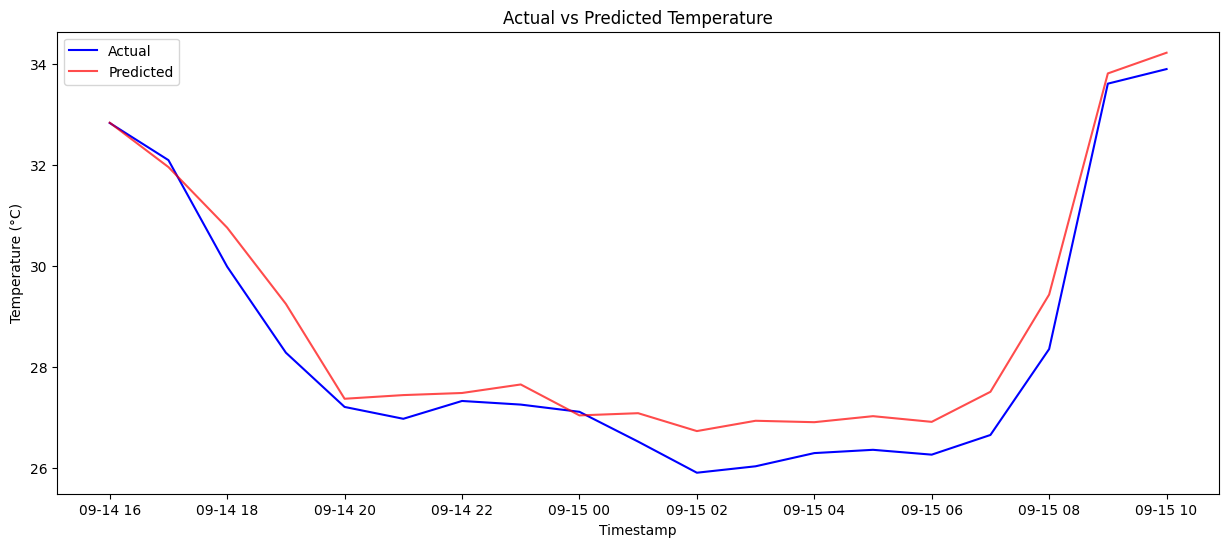

In [21]:
## Catboost regressor model and validation
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
cat_features = ['hour', 'day', 'month', 'year', 'week']
X_train = train.drop(['timestamp', 'temperature'], axis=1)
y_train = train['temperature']
X_val = val.drop(['timestamp', 'temperature'], axis=1)
y_val = val['temperature']
X_test = test.drop(['timestamp', 'temperature'], axis=1)
y_test = test['temperature']
model = CatBoostRegressor(iterations=300, learning_rate=0.4, depth=4, verbose=100)
model.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")
import numpy as np
y_pred_test = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"Test MAE: {mae_test:.2f}")
import numpy as np
print(f"Test RMSE: {rmse_test:.2f}")
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], y_test, label='Actual', color='b')
plt.plot(test['timestamp'], y_pred_test, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()

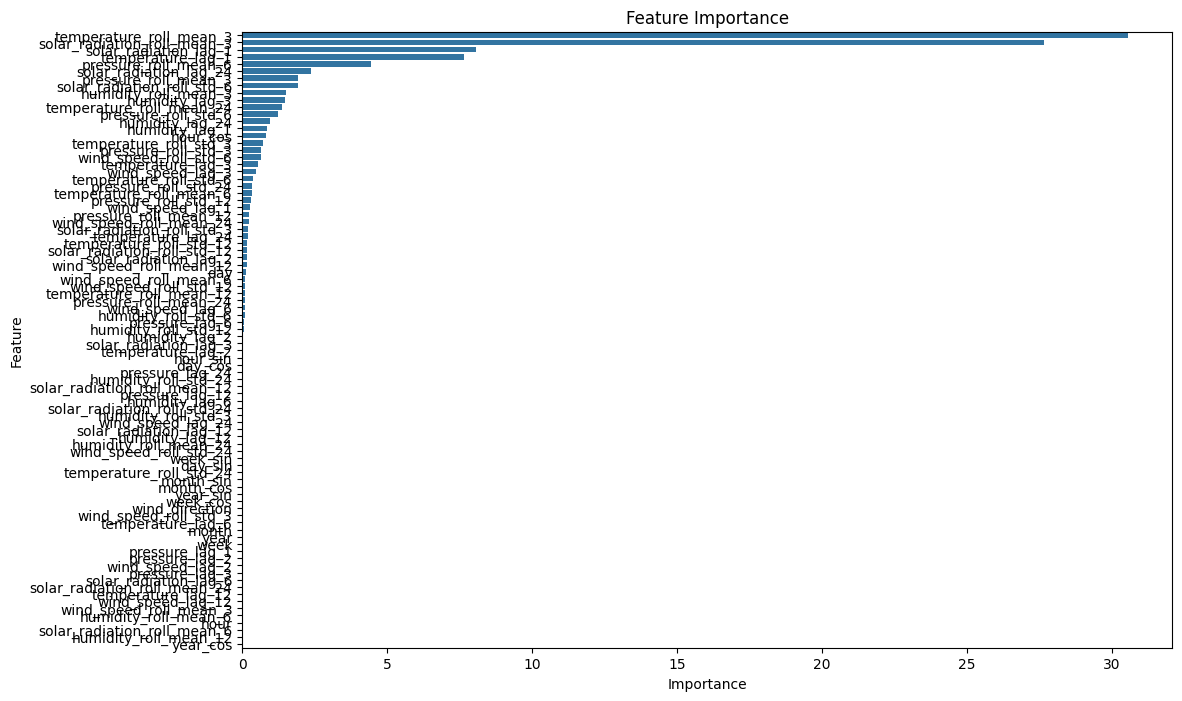

In [22]:
## Train feature importance
feature_importances = model.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.show()


In [41]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

def create_time_features(df):
    """Zaman özelliklerini oluştur"""
    df = df.copy()
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df["week"] = df['timestamp'].dt.isocalendar().week
    
    # Trigonometric features
    df["hour_sin"] = np.sin(2 * np.pi * df['hour'] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df['hour'] / 24)
    df["day_sin"] = np.sin(2 * np.pi * df['day'] / 31)
    df["day_cos"] = np.cos(2 * np.pi * df['day'] / 31)
    df["week_sin"] = np.sin(2 * np.pi * df['week'] / 52)
    df["week_cos"] = np.cos(2 * np.pi * df['week'] / 52)
    df["month_sin"] = np.sin(2 * np.pi * df['month'] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Year features (sadece bir değer varsa sorun olmasın)
    if df['year'].nunique() > 1:
        df["year_sin"] = np.sin(2 * np.pi * (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min()))
        df["year_cos"] = np.cos(2 * np.pi * (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min()))
    else:
        df["year_sin"] = 0
        df["year_cos"] = 1
    
    return df

def predict_next_6_hours_rolling(model, data, shift_values, window_sizes, target_col='temperature'):
    """
    Rolling prediction ile 6 saatlik tahmin
    """
    # Son veriyi kopyala ve genişlet
    extended_data = data.copy()
    predictions = []
    
    # Son timestamp'ten itibaren 6 saat için tarihler oluştur
    last_timestamp = data['timestamp'].max()
    future_timestamps = pd.date_range(
        start=last_timestamp + pd.Timedelta(hours=1), 
        periods=24, 
        freq='H'
    )
    
    print("Rolling prediction başlıyor...")
    
    for i, future_time in enumerate(future_timestamps):
        print(f"Adım {i+1}/6: {future_time} için tahmin yapılıyor...")
        
        # Yeni satır için temel bilgiler
        new_row = pd.DataFrame({
            'timestamp': [future_time],
            'temperature': [np.nan],  # Bu tahmin edilecek
            'humidity': [extended_data['humidity'].iloc[-1]],  # Son bilinen değeri kullan
            'pressure': [extended_data['pressure'].iloc[-1]],
            'wind_speed': [extended_data['wind_speed'].iloc[-1]],
            'solar_radiation': [extended_data['solar_radiation'].iloc[-1]]
        })
        
        # Geçici olarak yeni satırı ekle (tahmin için)
        temp_data = pd.concat([extended_data, new_row], ignore_index=True)
        
        # Zaman özelliklerini oluştur
        temp_data = create_time_features(temp_data)
        
        # Lag features oluştur
        for shift in shift_values:
            for col in ['temperature', 'humidity', 'pressure', 'wind_speed', 'solar_radiation']:
                temp_data[f'{col}_lag_{shift}'] = temp_data[col].shift(shift)
        
        # Rolling features oluştur
        for window in window_sizes:
            for col in ['temperature', 'humidity', 'pressure', 'wind_speed', 'solar_radiation']:
                temp_data[f'{col}_roll_mean_{window}'] = temp_data[col].rolling(window=window, min_periods=1).mean()
                temp_data[f'{col}_roll_std_{window}'] = temp_data[col].rolling(window=window, min_periods=1).std()
        
        # Son satırın feature'larını al (tahmin yapılacak satır)
        last_row = temp_data.iloc[-1:].copy()
        
        # NaN değerleri doldur
        last_row = last_row.fillna(method='ffill')
        if last_row.isnull().any().any():
            last_row = last_row.fillna(method='bfill')
        
        # Feature columns (timestamp ve target hariç)
        feature_cols = [col for col in last_row.columns if col not in ['timestamp', target_col]]
        X_pred = last_row[feature_cols]
        
        # Tahmin yap
        prediction = model.predict(X_pred)[0]
        predictions.append(prediction)
        
        # Tahmin edilen değeri gerçek veriye ekle
        new_row[target_col] = prediction
        extended_data = pd.concat([extended_data, new_row], ignore_index=True)
        
        print(f"  Tahmin: {prediction:.2f}")
    
    # Sonuçları döndür
    results_df = pd.DataFrame({
        'timestamp': future_timestamps,
        'predicted_temperature': predictions
    })
    
    return results_df, predictions

# Ana kullanım kodu
def main_prediction_pipeline(model, data, shift_values, window_sizes):
    """
    Ana tahmin pipeline'ı
    """
    print("Model eğitimi başlıyor...")
    
    # Veriyi hazırla
    model_data = data.copy()
    model_data = create_time_features(model_data)
    
    # Lag features
    for shift in shift_values:
        for col in ['temperature', 'humidity', 'pressure', 'wind_speed', 'solar_radiation']:
            model_data[f'{col}_lag_{shift}'] = model_data[col].shift(shift)
    
    # Rolling features
    for window in window_sizes:
        for col in ['temperature', 'humidity', 'pressure', 'wind_speed', 'solar_radiation']:
            model_data[f'{col}_roll_mean_{window}'] = model_data[col].rolling(window=window, min_periods=1).mean()
            model_data[f'{col}_roll_std_{window}'] = model_data[col].rolling(window=window, min_periods=1).std()
    
    # NaN değerleri temizle
    model_data = model_data.dropna()
    
    # Feature columns
    feature_cols = [col for col in model_data.columns if col not in ['timestamp', 'temperature']]
    X_train = model_data[feature_cols]
    y_train = model_data['temperature']
    
    # Modeli eğit
    model.fit(X_train, y_train)
    print("Model eğitimi tamamlandı!")
    
    # 6 saatlik tahmin yap
    results_df, predictions = predict_next_6_hours_rolling(
        model, data, shift_values, window_sizes
    )
    
    return results_df, predictions

# Kullanım örneği:
"""
# Parametrelerinizi tanımlayın
shift_values = [1, 2, 3, 6, 12, 24]  # örnek lag değerleri
window_sizes = [3, 6, 12, 24]        # örnek window boyutları

# Tahmin yapın
results_df, predictions = main_prediction_pipeline(model, data, shift_values, window_sizes)

# Sonuçları göster
print("\n6 Saatlik Tahmin Sonuçları:")
print(results_df)
"""

# Alternatif: Ensemble yaklaşımı için
def ensemble_prediction(models, data, shift_values, window_sizes, weights=None):
    """
    Birden fazla model ile ensemble tahmin
    """
    if weights is None:
        weights = [1.0 / len(models)] * len(models)
    
    all_predictions = []
    
    for i, model in enumerate(models):
        print(f"Model {i+1}/{len(models)} ile tahmin yapılıyor...")
        results_df, predictions = predict_next_6_hours_rolling(
            model, data, shift_values, window_sizes
        )
        all_predictions.append(predictions)
    
    # Weighted average
    ensemble_predictions = np.average(all_predictions, axis=0, weights=weights)
    
    future_timestamps = pd.date_range(
        start=data['timestamp'].max() + pd.Timedelta(hours=1), 
        periods=6, 
        freq='H'
    )
    
    ensemble_results = pd.DataFrame({
        'timestamp': future_timestamps,
        'predicted_temperature': ensemble_predictions
    })
    
    return ensemble_results, ensemble_predictions

In [42]:
# Mevcut parametrelerinizi kullanın
shift_values = [1, 2, 3, 6, 12, 24]  # sizin shift değerleriniz
window_sizes = [3, 6, 12, 24]        # sizin window boyutlarınız

# Ana tahmin fonksiyonu
results_df, predictions = main_prediction_pipeline(model, data, shift_values, window_sizes)

# Sonuçları görüntüle
print(results_df)

Model eğitimi başlıyor...
0:	learn: 2.4033926	total: 3.11ms	remaining: 931ms
100:	learn: 0.0199000	total: 219ms	remaining: 432ms
200:	learn: 0.0013453	total: 418ms	remaining: 206ms
299:	learn: 0.0001192	total: 631ms	remaining: 0us
Model eğitimi tamamlandı!
Rolling prediction başlıyor...
Adım 1/6: 2025-09-15 11:00:00+00:00 için tahmin yapılıyor...
  Tahmin: 33.32
Adım 2/6: 2025-09-15 12:00:00+00:00 için tahmin yapılıyor...
  Tahmin: 33.14
Adım 3/6: 2025-09-15 13:00:00+00:00 için tahmin yapılıyor...
  Tahmin: 33.19
Adım 4/6: 2025-09-15 14:00:00+00:00 için tahmin yapılıyor...
  Tahmin: 33.20
Adım 5/6: 2025-09-15 15:00:00+00:00 için tahmin yapılıyor...
  Tahmin: 33.00
Adım 6/6: 2025-09-15 16:00:00+00:00 için tahmin yapılıyor...
  Tahmin: 32.86
Adım 7/6: 2025-09-15 17:00:00+00:00 için tahmin yapılıyor...
  Tahmin: 32.69
Adım 8/6: 2025-09-15 18:00:00+00:00 için tahmin yapılıyor...
  Tahmin: 31.98
Adım 9/6: 2025-09-15 19:00:00+00:00 için tahmin yapılıyor...
  Tahmin: 31.07
Adım 10/6: 2025-09-

In [33]:
import psycopg2.extras as extras

def execute_values(conn, df, table):

    tuples = [tuple(x) for x in df.to_numpy()]

    cols = ','.join(list(df.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("the dataframe is inserted")
    cursor.close()


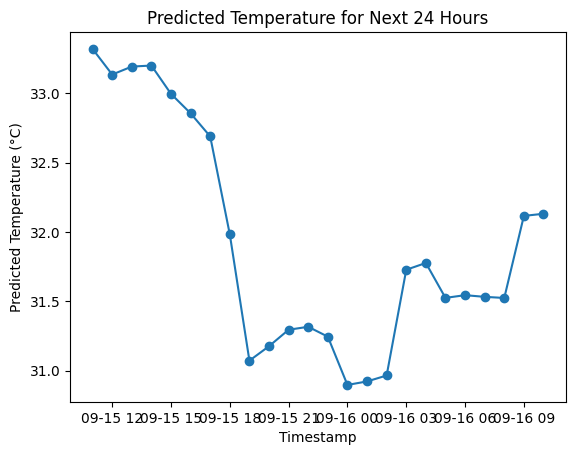

In [44]:
plt.plot(results_df['timestamp'], results_df['predicted_temperature'], marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Predicted Temperature for Next 24 Hours')
plt.show()

In [39]:
results_df.drop(["id"], axis=1, inplace=True)

In [46]:
#results_df["id"] = 1
results_df.columns = ["timestamp", "temp_prediction", "device_id"]
execute_values(conn=connection, df=results_df, table='public.predictions')


the dataframe is inserted
